<a href="https://colab.research.google.com/github/proninivandm/cv_task/blob/main/CV_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!wget -q -P /content/save/positive/ -i /content/drive/MyDrive/georges.csv

In [3]:
!wget -q -P /content/save/negative/ -i /content/drive/MyDrive/non_georges.csv

In [2]:
device = torch.device('cuda')
image_size = (128,196)
batch_size = 64
transform = torchvision.transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # Normalize здесь приводит значения в промежуток [-1, 1]
])
dataset = torchvision.datasets.ImageFolder(root='/content/save', transform=transform)
len=dataset.__len__()

In [3]:
train, val = torch.utils.data.random_split(dataset, [int(len*0.8), int(len*0.2)])

In [4]:
train_loader =  torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader =  torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

val_size = val.__len__()
train_size = train.__len__()

In [13]:
resnet = torchvision.models.resnet101(pretrained=True, progress=True).to(device)

In [14]:
resnet.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512,1),
    nn.Sigmoid()
).to(device)

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)

resnet.fc.apply(weights_init)
epochs = 10
criterion = nn.BCELoss()
opt = torch.optim.SGD(resnet.parameters(), lr=4e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, 4)
losses = []
accs=[]

Epoch: 0


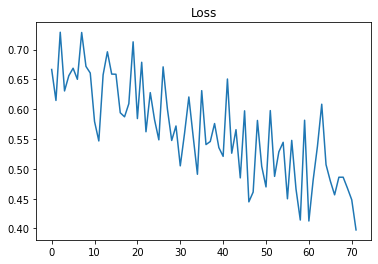

accuracy: 0.8201754093170166


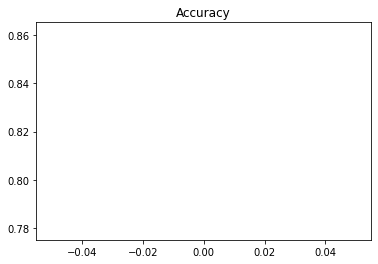

Epoch: 1


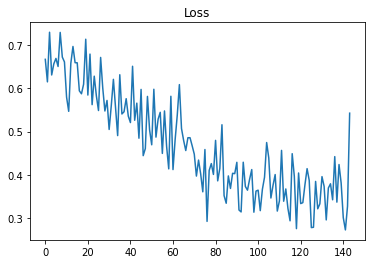

accuracy: 0.8456140160560608
Epoch: 2


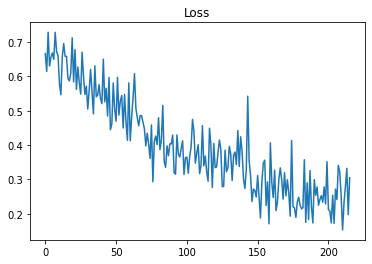

accuracy: 0.8798245787620544
Epoch: 3


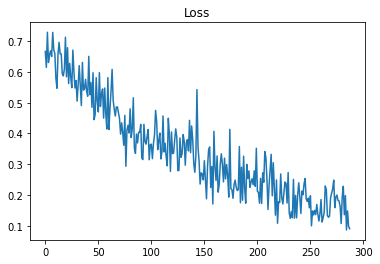

accuracy: 0.8885964751243591
Epoch: 4


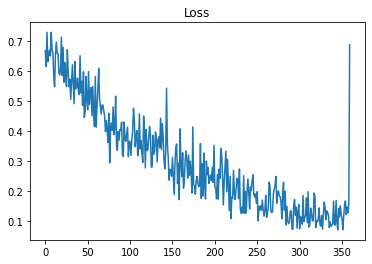

accuracy: 0.8885964751243591
Epoch: 5


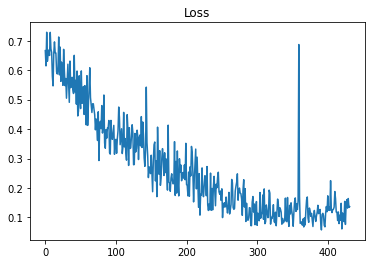

accuracy: 0.8877192735671997


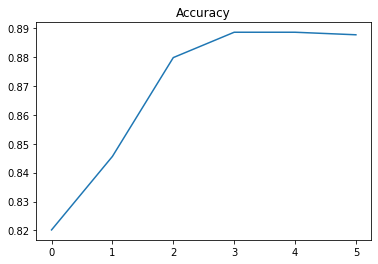

Epoch: 6


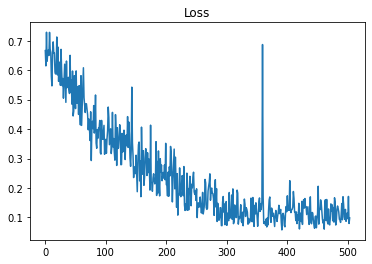

accuracy: 0.8929824829101562
Epoch: 7


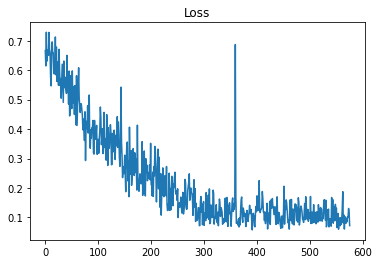

accuracy: 0.8956140279769897
Epoch: 8


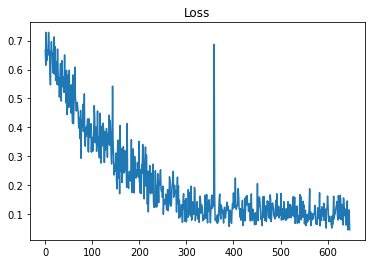

accuracy: 0.890350878238678
Epoch: 9


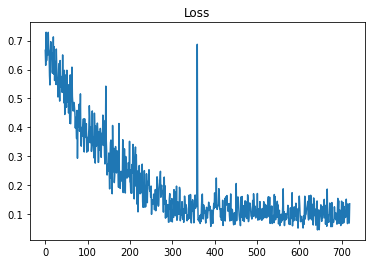

accuracy: 0.8947368264198303


In [16]:
for epoch in range(epochs):
  for X, y in train_loader:
    X = X.to(device)
    y = y.to(device).float()

    opt.zero_grad()
    resnet.train()
    probas = resnet(X).squeeze(1)
    loss = criterion(probas, y)
    loss.backward()
    opt.step()
    losses.append(loss.cpu().item())
  sched.step()
  print(f"Epoch: {epoch}")
  plt.plot(losses)
  plt.title('Loss')
  plt.show()
  correct=0
  resnet.eval()
  for X, y in val_loader:
    preds = torch.round(resnet(X.to(device))).cpu().view((-1))
    correct += (preds == y).float().sum()
  accs.append(correct/val_size)
  print(f"accuracy: {correct/val_size}")
  if (epoch % 5 == 0):
    plt.plot(accs)
    plt.title('Accuracy')
    plt.show()
  torch.cuda.empty_cache()

In [17]:
torch.save(resnet.state_dict(), '/content/clf_georg.pt')

In [43]:
def predict(img, model):
  model.eval()
  img=transform(img).unsqueeze(0)
  pred = round(model(img).detach().item())
  print(f'There is  {"no" if pred==0 else ""} Georgy on a  picture')
  return pred

In [20]:
import PIL

In [24]:
image_pos = PIL.Image.open('/content/save/positive/0018b7f3006c03e479018e609629d226.jpg.2')

In [44]:
predict(image_pos, resnet.cpu())

There is   Georgy on a  picture


1

In [45]:
image_neg = PIL.Image.open('/content/save/negative/003d4e46a416fd1ccdc9deb20a079865.jpg')

In [46]:
predict(image_neg, resnet.cpu())

There is  no Georgy on a  picture


0